# pm2.5 training notebook

In [1]:
import json
import datetime as dt
import pytz
import requests

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model, metrics, model_selection

## Functions that get data from server to us

In [2]:
def get_data_by_pos(pos):
    r = requests.get(f'http://140.116.82.93:6800/campus/display/{ pos }')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

In [3]:
def get_all_data():
    r = requests.get(f'http://140.116.82.93:6800/training')
    # date field in self.data is the str of datetime
    # We need to convert it to timezone aware object first
    data = json.loads(r.text)
    for index, value in enumerate(data):
      # strptime() parse str of date according to the format given behind
      # It is still naive datetime object, meaning that it is unaware of timezone
      unaware = dt.datetime.strptime(value.get('date'),  '%a, %d %b %Y %H:%M:%S %Z')
      # Create a utc timezone
      utc_timezone = pytz.timezone('UTC')
      # make utc_unaware obj aware of timezone
      # Convert the given time directly to literally the same time with different timezone
      # For example: Change from 2019-05-19 07:41:13(unaware) to 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC)
      utc_aware = utc_timezone.localize(unaware)
      # This can also do the same thing
      # Replace the tzinfo of an unaware datetime object to a given tzinfo
      # utc_aware = unaware.replace(tzinfo=pytz.utc)

      # Transform utc timezone to +8 GMT timezone
      # Convert the given time to the same moment of time just like performing timezone calculation
      # For example: Change from 2019-05-19 07:41:13+00:00(aware, tzinfo=UTC) to 2019-05-19 15:41:13+08:00(aware, tzinfo=Asiz/Taipei)
      taiwan_aware = utc_aware.astimezone(pytz.timezone('Asia/Taipei'))
      # print(f"{ index }: {unaware} {utc_aware} {taiwan_aware}")
      value['date'] = taiwan_aware
    return data

## 特定一個 position 的 Linear Regression

暫定的做法是：將每一小時的資料做平均，然後將下一小時的 pm2.5 平均當作想要預測的 y。如果下一小時的 pm2.5 平均無法取得(資料缺失)，則將該 row 捨棄。拿來訓練的 columns 目前有 'month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity'。

### Load data


In [63]:
data3 = get_data_by_pos(3)

In [64]:
df3 = pd.DataFrame(data3)

In [65]:
df3.head()

,date,humidity,pm10,pm100,pm25,temp
0,2019-05-11 09:28:17+08:00,62,50,94,78,28
1,2019-05-11 09:43:14+08:00,61,36,71,60,29
2,2019-05-11 09:58:13+08:00,59,39,75,63,29
3,2019-05-11 10:13:10+08:00,59,41,78,66,29
4,2019-05-11 10:28:07+08:00,59,33,67,52,30


### Data preprocessing

In [7]:
# rename the names of columns
df3 = df3.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})

In [8]:
# split time infomation from column `date`
df3['month'] = df3['date'].apply(lambda x: x.month)
df3['day'] = df3['date'].apply(lambda x: x.day)
df3['weekday'] = df3['date'].apply(lambda x: x.weekday)
df3['hour'] = df3['date'].apply(lambda x: x.hour)
df3['hour_minute'] = df3['date'].apply(lambda x: x.hour+x.minute/60)

In [9]:
# set the order of the columns & discard some columns
df3 = df3[['month', 'day', 'weekday', 'hour', 'hour_minute', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]

In [10]:
df3.head()

,month,day,weekday,hour,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
0,5,11,5,9,9.466667,50,78,94,28,62
1,5,11,5,9,9.716667,36,60,71,29,61
2,5,11,5,9,9.966667,39,63,75,29,59
3,5,11,5,10,10.216667,41,66,78,29,59
4,5,11,5,10,10.466667,33,52,67,30,59


In [11]:
# evaluate mean values for each hour
df3mean = df3.groupby(['month', 'day', 'hour']).mean()

In [12]:
df3mean

weekday  hour_minute      pm1.0  pm2.5  pm10.0       temp  \
month day hour                                                              
5     11  9         5.0     9.716667  41.666667  67.00   80.00  28.666667   
          10        5.0    10.591667  37.250000  59.75   72.75  29.750000   
          11        5.0    11.575000  28.500000  44.25   56.25  31.750000   
          12        5.0    12.575000  21.500000  32.00   37.00  35.000000   
          13        5.0    13.575000  18.500000  23.75   24.75  37.250000   
          14        5.0    14.575000  17.000000  22.50   23.50  37.750000   
          15        5.0    15.575000  19.000000  25.25   26.25  36.000000   
          16        5.0    16.575000  19.750000  26.50   29.00  32.500000   
          17        5.0    17.575000  14.250000  20.00   20.75  29.000000   
          18        5.0    18.575000  12.250000  17.25   18.75  27.000000   
          19        5.0    19.566667  15.750000  21.50   23.50  26.000000   
          20        5.0    20.558333  16.250000  23.25   26.00  26.000000   
          21        5.0    21.558333  17.000000  27.25   29.50  26.000000   
          22        5.0    22.558333  21.750000  33.25   39.25  26.000000   
          23        5.0    23.558333  24.500000  36.50   45.00  25.250000   
      12  0         6.0     0.558333  28.250000  42.50   54.00  25.000000   
          1         6.0     1.541667  28.750000  44.25   55.00  25.000000   
          2         6.0     2.541667  28.250000  42.75   53.00  24.750000   
          3         6.0     3.541667  28.250000  43.25   56.25  24.000000   
          4         6.0     4.541667  31.000000  49.00   63.00  24.000000   
          5         6.0     5.541667  28.750000  47.50   60.75  24.000000   
          6         6.0     6.541667  29.250000  47.25   60.75  24.500000   
          7         6.0     7.525000  30.000000  46.75   59.75  25.750000   
          8         6.0     8.525000  29.500000  46.75   61.75  27.250000   
          9         6.0     9.525000  27.500000  44.00   55.25  29.000000   
          10        6.0    10.525000  31.000000  48.00   62.00  30.000000   
          11        6.0    11.525000  29.250000  44.00   54.00  31.000000   
          12        6.0    12.525000  24.000000  37.00   43.50  32.500000   
          13        6.0    13.508333  21.500000  32.00   36.50  34.250000   
          14        6.0    14.508333  21.500000  32.75   38.00  35.250000   
...                 ...          ...        ...    ...     ...        ...   
7     26  14        4.0    14.541667   6.500000   7.75    8.75  31.250000   
          15        4.0    15.541667   6.250000   7.50    8.00  31.000000   
          16        4.0    16.541667   7.750000   9.00   10.00  31.000000   
          17        4.0    17.541667   8.000000   9.50   10.00  30.000000   
          18        4.0    18.541667   7.000000   8.25    8.75  30.000000   
          19        4.0    19.541667   9.000000  11.75   12.00  30.000000   
          20        4.0    20.541667  11.000000  14.00   14.50  29.250000   
          21        4.0    21.541667  12.750000  16.25   16.50  29.000000   
          22        4.0    22.541667  13.000000  17.75   19.25  28.000000   
          23        4.0    23.525000  12.500000  15.25   16.75  28.000000   
      27  0         5.0     0.525000   9.500000  12.25   13.50  27.750000   
          1         5.0     1.525000   8.250000  10.75   11.25  27.250000   
          2         5.0     2.525000  10.000000  12.75   14.25  27.750000   
          3         5.0     3.525000   8.750000  11.25   12.50  27.750000   
          4         5.0     4.525000   7.500000   9.00   10.25  27.750000   
          5         5.0     5.525000   7.750000   9.75   10.25  28.000000   
          6         5.0     6.525000   6.750000   8.50   11.00  28.000000   
          7         5.0     7.525000   6.250000   7.75    9.25  28.000000   
          8         5.0     8.525000   1.250000   1.75    2.50  28.000000   
          9 

In [13]:
df3mean.reset_index(inplace=True)

In [14]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity
0,5,11,9,5.0,9.716667,41.666667,67.00,80.00,28.666667,60.666667
1,5,11,10,5.0,10.591667,37.250000,59.75,72.75,29.750000,58.000000
2,5,11,11,5.0,11.575000,28.500000,44.25,56.25,31.750000,51.500000
3,5,11,12,5.0,12.575000,21.500000,32.00,37.00,35.000000,43.500000
4,5,11,13,5.0,13.575000,18.500000,23.75,24.75,37.250000,37.750000


In [15]:
# reconstruct time infomation by `month`, `day`, and `hour`

def get_time(x):
    time_str = '2019 %d %d %d' % (x[0], x[1], x[2])
    taipei_tz = pytz.timezone('Asia/Taipei')
    time = dt.datetime.strptime(time_str, '%Y %m %d %H').replace(tzinfo=taipei_tz)
    return time

df3mean['time'] = df3mean[['month', 'day', 'hour']].apply(get_time, axis=1)

In [16]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,time
0,5,11,9,5.0,9.716667,41.666667,67.00,80.00,28.666667,60.666667,2019-05-11 08:54:00+08:00
1,5,11,10,5.0,10.591667,37.250000,59.75,72.75,29.750000,58.000000,2019-05-11 09:54:00+08:00
2,5,11,11,5.0,11.575000,28.500000,44.25,56.25,31.750000,51.500000,2019-05-11 10:54:00+08:00
3,5,11,12,5.0,12.575000,21.500000,32.00,37.00,35.000000,43.500000,2019-05-11 11:54:00+08:00
4,5,11,13,5.0,13.575000,18.500000,23.75,24.75,37.250000,37.750000,2019-05-11 12:54:00+08:00


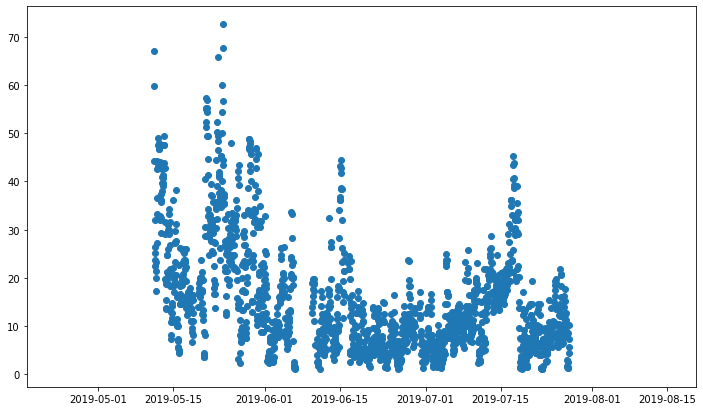

In [17]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()

# plt
plt.figure(figsize=(12, 7))
plt.scatter(df3mean['time'], df3mean['pm2.5'])


In [18]:
df3mean[['pm2.5_shift-1']] = df3mean[['pm2.5']].shift(-1)

In [19]:
df3mean[['time_shift-1']] = df3mean[['time']].shift(-1)

In [20]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,time,pm2.5_shift-1,time_shift-1
0,5,11,9,5.0,9.716667,41.666667,67.00,80.00,28.666667,60.666667,2019-05-11 08:54:00+08:00,59.75,2019-05-11 09:54:00+08:00
1,5,11,10,5.0,10.591667,37.250000,59.75,72.75,29.750000,58.000000,2019-05-11 09:54:00+08:00,44.25,2019-05-11 10:54:00+08:00
2,5,11,11,5.0,11.575000,28.500000,44.25,56.25,31.750000,51.500000,2019-05-11 10:54:00+08:00,32.00,2019-05-11 11:54:00+08:00
3,5,11,12,5.0,12.575000,21.500000,32.00,37.00,35.000000,43.500000,2019-05-11 11:54:00+08:00,23.75,2019-05-11 12:54:00+08:00
4,5,11,13,5.0,13.575000,18.500000,23.75,24.75,37.250000,37.750000,2019-05-11 12:54:00+08:00,22.50,2019-05-11 13:54:00+08:00


In [21]:
# check the next row is the next hour or not. 
# If it is not, the `pm2.5_next_hour` column will be given NaN.

def check_next_hour(x):
    one_hour = dt.timedelta(hours=1)
    if x[2] - x[1] == one_hour:
        return x[0]
    return np.nan

df3mean['pm2.5_next_hour'] = df3mean[['pm2.5_shift-1', 'time', 'time_shift-1']].apply(check_next_hour, axis=1)

In [22]:
df3mean.head()

,month,day,hour,weekday,hour_minute,pm1.0,pm2.5,pm10.0,temp,humidity,time,pm2.5_shift-1,time_shift-1,pm2.5_next_hour
0,5,11,9,5.0,9.716667,41.666667,67.00,80.00,28.666667,60.666667,2019-05-11 08:54:00+08:00,59.75,2019-05-11 09:54:00+08:00,59.75
1,5,11,10,5.0,10.591667,37.250000,59.75,72.75,29.750000,58.000000,2019-05-11 09:54:00+08:00,44.25,2019-05-11 10:54:00+08:00,44.25
2,5,11,11,5.0,11.575000,28.500000,44.25,56.25,31.750000,51.500000,2019-05-11 10:54:00+08:00,32.00,2019-05-11 11:54:00+08:00,32.00
3,5,11,12,5.0,12.575000,21.500000,32.00,37.00,35.000000,43.500000,2019-05-11 11:54:00+08:00,23.75,2019-05-11 12:54:00+08:00,23.75
4,5,11,13,5.0,13.575000,18.500000,23.75,24.75,37.250000,37.750000,2019-05-11 12:54:00+08:00,22.50,2019-05-11 13:54:00+08:00,22.50


In [23]:
df3mean.isna().sum()

month               0
day                 0
hour                0
weekday             0
hour_minute         0
pm1.0               0
pm2.5               0
pm10.0              0
temp                0
humidity            0
time                0
pm2.5_shift-1       1
time_shift-1        1
pm2.5_next_hour    10
dtype: int64

In [24]:
# discard rows that contain NaN value
df3mean.dropna(inplace=True)

In [25]:
df3mean.isna().sum()

month              0
day                0
hour               0
weekday            0
hour_minute        0
pm1.0              0
pm2.5              0
pm10.0             0
temp               0
humidity           0
time               0
pm2.5_shift-1      0
time_shift-1       0
pm2.5_next_hour    0
dtype: int64

### Normalization

$z = \frac{x- \mu}{\sigma}$


In [26]:
df3mean_time = df3mean['time_shift-1']
df3mean.drop(columns=['time', 'time_shift-1'], axis=0, inplace=True)

df3mean = (df3mean - df3mean.mean()) / df3mean.std()

### Divid training set and test set

In [27]:
four_fifth_len = len(df3mean)*0.8
four_fifth_len = int(four_fifth_len)

In [28]:
train_df = df3mean[:four_fifth_len]
test_df = df3mean[four_fifth_len:]

test_df_time = df3mean_time[four_fifth_len:]

In [29]:
X = train_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
y = train_df[['pm2.5_next_hour']]

In [30]:
test_X = test_df[['month', 'day', 'weekday', 'hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
test_y = test_df[['pm2.5_next_hour']]

### Fit the model

using `sklearn.linear_model.LinearRegression`

In [31]:
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [32]:
# see the coefficients of our model
a = model.coef_
b = model.intercept_
print(a)
print(b)

[[-0.06673449 -0.02076596  0.00818317  0.02111373  0.14750897  0.44110329
   0.29230828 -0.1613255  -0.12303692]]
[-0.02018903]


In [33]:
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], model.coef_[0][i]))

Coefficient for      month:	-0.06673448917249805
Coefficient for        day:	-0.020765963176863793
Coefficient for    weekday:	0.00818317004738342
Coefficient for       hour:	0.021113733460433763
Coefficient for      pm1.0:	0.14750897316122275
Coefficient for      pm2.5:	0.44110328816933764
Coefficient for     pm10.0:	0.29230828307977125
Coefficient for       temp:	-0.16132549546242422
Coefficient for   humidity:	-0.12303691558118002


In [34]:
# calculate mean squared error for training set & test set
predict_train_y = model.predict(X)
predict_y = model.predict(test_X)

train_mse = metrics.mean_squared_error(y, predict_train_y)
test_mse = metrics.mean_squared_error(test_y, predict_y)

print('Train MSE:\t %s' % train_mse)
print('Test MSE:\t %s' % test_mse)

Train MSE:	 0.12641641218545266
Test MSE:	 0.09215633601916776


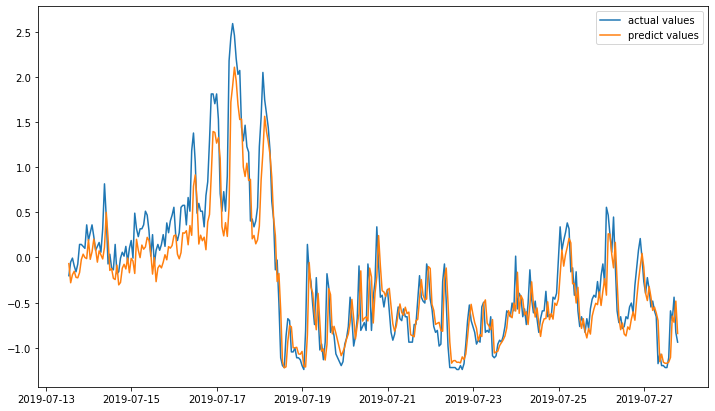

In [35]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()

# plt
plt.figure(figsize=(12, 7))
plt.plot(test_df_time, test_df['pm2.5_next_hour'], label='actual values')
plt.plot(test_df_time, predict_y, label='predict values')
plt.legend()
plt.show()

### Feature Selection via Ridge Regression

~~Our test error is worse than our training error. Therefore, our next job is to improve this.~~

Next, we improve mean squared error. 

We use the class `sklearn.linear_model.Ridge`. We will throw all features in, let ridge regression do selection, and see how our own feature sets compare. Notice we have an additional hyperparameter,  𝛼 . This controls how heavy the penalty is for larger weights.

To perform hyperparameter tuning we can use a technique called **cross validation**. We take our test set, randomly divide into  𝑘  training and testing sets. Differnent samples will be randomly placed in each set, each with their own variance. We then average the results over the folds to estimate how well we will do on unseen test data. After splitting the data into  𝑘  folds (10 is a usual choice for  𝑘 ), we will try out different hyperparameter values and select the best one. Much of this process is already wrapped in `sklearn.model_selection.cross_val_score` for us. We just need to define a scoring function.


In [36]:
# define a scoring function
def scorer(model, X, y):
    preds = model.predict(X)
    return metrics.mean_squared_error(y, preds)

In [37]:
# define a range of values for alpha to search over.
alphas = np.linspace(start=0, stop=0.03, num=11)

mses = []
for alpha in alphas:
    ridge = linear_model.Ridge(alpha=alpha, normalize=True)
    mse = model_selection.cross_val_score(ridge, X, y, cv=10, scoring=scorer)
    mses.append(mse.mean())

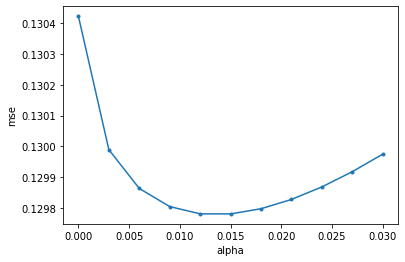

In [38]:
plt.plot(alphas, mses, marker='.')
plt.xlabel('alpha')
plt.ylabel('mse')
plt.show()

In [39]:
best_alpha = alphas[np.argmin(mses)]
best_alpha

0.015

In [40]:
# Use `best_alpha` to fit the model
ridge = linear_model.Ridge(alpha=best_alpha, normalize=True)
ridge.fit(X, y)

Ridge(alpha=0.015, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=True, random_state=None, solver='auto', tol=0.001)

In [41]:
for i in range(len(X.columns)):
    print('Coefficient for %10s:\t%s' % (X.columns[i], ridge.coef_[0][i]))

Coefficient for      month:	-0.07174791324284559
Coefficient for        day:	-0.01991365834670473
Coefficient for    weekday:	0.008612845788602443
Coefficient for       hour:	0.01913072369684454
Coefficient for      pm1.0:	0.24987523693901828
Coefficient for      pm2.5:	0.3061481859290755
Coefficient for     pm10.0:	0.32132659660209983
Coefficient for       temp:	-0.147696346844804
Coefficient for   humidity:	-0.10648063376488365


In [42]:
predict_train_y = ridge.predict(X)
predict_y = ridge.predict(test_X)

train_mse = metrics.mean_squared_error(y, predict_train_y)
test_mse = metrics.mean_squared_error(test_y, predict_y)

print('Train MSE:\t %s' % train_mse)
print('Test MSE:\t %s' % test_mse)

Train MSE:	 0.1265778572811163
Test MSE:	 0.09233313504660719


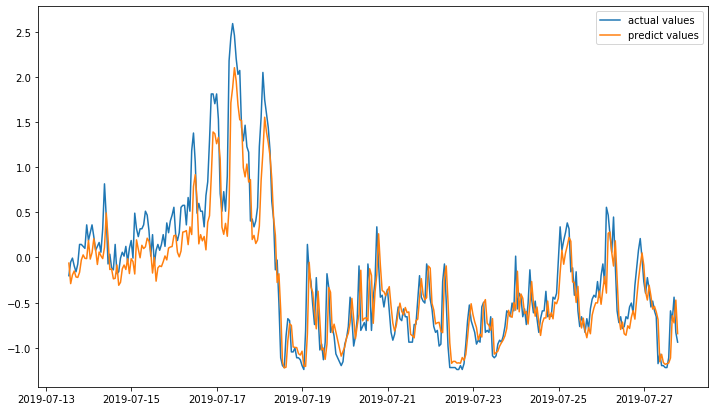

In [43]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()

# plt
plt.figure(figsize=(12, 7))
plt.plot(test_df_time, test_df['pm2.5_next_hour'], label='actual values')
plt.plot(test_df_time, predict_y, label='predict values')
plt.legend()
plt.show()

### Feature Selection by myself

In [44]:
# Select features I want
X_fsm = X[['hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]
test_X_fsm = test_X[['hour', 'pm1.0', 'pm2.5', 'pm10.0', 'temp', 'humidity']]

In [45]:
# Fit the model
model = linear_model.LinearRegression(normalize=True)
model.fit(X_fsm, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=True)

In [46]:
for i in range(len(X_fsm.columns)):
    print('Coefficient for %10s:\t%s' % (X_fsm.columns[i], model.coef_[0][i]))

Coefficient for       hour:	0.023992703220373113
Coefficient for      pm1.0:	0.09956158555804434
Coefficient for      pm2.5:	0.5848042206704666
Coefficient for     pm10.0:	0.22008630899264398
Coefficient for       temp:	-0.17135110136180298
Coefficient for   humidity:	-0.14471412810114898


In [47]:
predict_train_y = model.predict(X_fsm)
predict_y = model.predict(test_X_fsm)

train_mse = metrics.mean_squared_error(y, predict_train_y)
test_mse = metrics.mean_squared_error(test_y, predict_y)

print('Train MSE:\t %s' % train_mse)
print('Test MSE:\t %s' % test_mse)

Train MSE:	 0.12802561441166813
Test MSE:	 0.07857232041341457


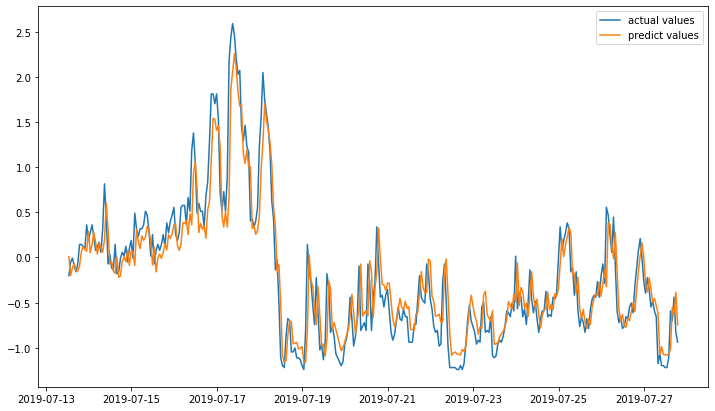

In [48]:
# Add explicitly converter
pd.plotting.register_matplotlib_converters()

# plt
plt.figure(figsize=(12, 7))
plt.plot(test_df_time, test_df['pm2.5_next_hour'], label='actual values')
plt.plot(test_df_time, predict_y, label='predict values')
plt.legend()
plt.show()

## 不區分 Position 的 Linear Regression

未完成...

### Load data


In [49]:
data = get_all_data()

In [50]:
df = pd.DataFrame(data)

### Data preprocessing

In [51]:
# rename the names of columns
df = df.rename(columns = {'pm10': 'pm1.0', 'pm25': 'pm2.5', 'pm100': 'pm10.0'})

In [52]:
df.head()

,_cls,date,humidity,pm1.0,pm10.0,pm2.5,position,temp
0,models.data_model.PMData,2019-05-11 09:28:17+08:00,62,50,94,78,3,28
1,models.data_model.PMData,2019-05-11 09:29:44+08:00,67,42,81,72,5,27
2,models.data_model.PMData,2019-05-11 09:43:14+08:00,61,36,71,60,3,29
3,models.data_model.PMData,2019-05-11 09:44:42+08:00,67,41,82,70,5,27
4,models.data_model.PMData,2019-05-11 09:58:13+08:00,59,39,75,63,3,29


In [53]:
df['month'] = df['date'].apply(lambda x: x.month)
df['day'] = df['date'].apply(lambda x: x.day)
df['weekday'] = df['date'].apply(lambda x: x.weekday)
df['hour'] = df['date'].apply(lambda x: x.hour)
df['hour_minute'] = df['date'].apply(lambda x: x.hour+x.minute/60)

In [54]:
df.head()

,_cls,date,humidity,pm1.0,pm10.0,pm2.5,position,temp,month,day,weekday,hour,hour_minute
0,models.data_model.PMData,2019-05-11 09:28:17+08:00,62,50,94,78,3,28,5,11,5,9,9.466667
1,models.data_model.PMData,2019-05-11 09:29:44+08:00,67,42,81,72,5,27,5,11,5,9,9.483333
2,models.data_model.PMData,2019-05-11 09:43:14+08:00,61,36,71,60,3,29,5,11,5,9,9.716667
3,models.data_model.PMData,2019-05-11 09:44:42+08:00,67,41,82,70,5,27,5,11,5,9,9.733333
4,models.data_model.PMData,2019-05-11 09:58:13+08:00,59,39,75,63,3,29,5,11,5,9,9.966667


In [55]:
df.drop(columns=['_cls', 'date'], inplace=True)
df.head()

,humidity,pm1.0,pm10.0,pm2.5,position,temp,month,day,weekday,hour,hour_minute
0,62,50,94,78,3,28,5,11,5,9,9.466667
1,67,42,81,72,5,27,5,11,5,9,9.483333
2,61,36,71,60,3,29,5,11,5,9,9.716667
3,67,41,82,70,5,27,5,11,5,9,9.733333
4,59,39,75,63,3,29,5,11,5,9,9.966667


In [56]:
df[['pm2.5_next']] = df[['pm2.5']].shift(-1)

In [57]:
df.dropna(inplace=True)
df.tail()

,humidity,pm1.0,pm10.0,pm2.5,position,temp,month,day,weekday,hour,hour_minute,pm2.5_next
43544,73,6,6,6,0,27,7,27,5,19,19.816667,7.0
43545,65,5,7,7,5,28,7,27,5,19,19.833333,6.0
43546,63,4,6,6,3,29,7,27,5,19,19.833333,8.0
43547,66,7,8,8,7,27,7,27,5,19,19.950000,7.0
43548,67,6,9,7,1,27,7,27,5,19,19.950000,7.0


In [58]:
four_fifth_len = len(df)*0.8
four_fifth_len = int(four_fifth_len)

In [59]:
train_df = df[:four_fifth_len]
test_df = df[four_fifth_len:]

In [60]:
X = train_df[['month', 'day', 'hour', 'pm1.0', 'pm10.0', 'pm2.5', 'temp', 'humidity', 'position']]
y = train_df[['pm2.5_next']]

In [61]:
test_X = test_df[['month', 'day', 'hour', 'pm1.0', 'pm10.0', 'pm2.5', 'temp', 'humidity', 'position']]
test_y = test_df[['pm2.5_next']]